# Alphamind新手入门之七：单因子分析

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from alphamind.api import *
from PyFin.api import *

from matplotlib import rc
from matplotlib import pyplot as plt

plt.style.use("seaborn-poster")
rc('font', **{'family': 'Microsoft Yahei', 'size': 10})
rc('mathtext', **{'default': 'regular'})
rc('legend', **{'frameon': False})

## 1. 准备因子历史数据
-----------------------

In [2]:
factor_name = 'EMA5D' # 设置因子名称
neutralized_styles = risk_styles + industry_styles #设置中性化因子名称
start_date = '2015-01-01'
end_date = '2020-02-01'
engine = SqlEngine(os.environ['DB_URI'])
universe_name = 'ashare' # 股票池
freq = '5b' # 调仓频率

In [3]:
# 相关数据的获取
# 包括因子值获取、风险模型数据、股票收益率数据

universe = Universe(universe_name) # 股票池设置
dates = makeSchedule(start_date, end_date, freq, calendar='china.sse')
factors = engine.fetch_factor_range(universe, factor_name, dates=dates) #获取因子值
risk_cov, risk_factors = engine.fetch_risk_model_range(universe, dates=dates) # 获取风险模型数据 
dx_returns = engine.fetch_dx_return_range(universe, dates=dates, horizon=map_freq(freq))  #获取股票收益率数据
total_data = pd.merge(factors, risk_factors, on=['trade_date', 'code'])
total_data = pd.merge(total_data, dx_returns, on=['trade_date', 'code'])
total_data.dropna(inplace=True)

## 2. 计算历史IC序列
----------------------

In [4]:
# 因子中性化
# 对neutralized_styles的因子进行中性化

neutralized_factors = neutralize(total_data[neutralized_styles].values.astype(float),
                                 total_data['EMA5D'].values,
                                 groups=total_data['trade_date'].values)
total_data['neutralized_factors'] = neutralized_factors

<AxesSubplot:xlabel='trade_date'>

findfont: Font family ['Microsoft Yahei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Microsoft Yahei'] not found. Falling back to DejaVu Sans.


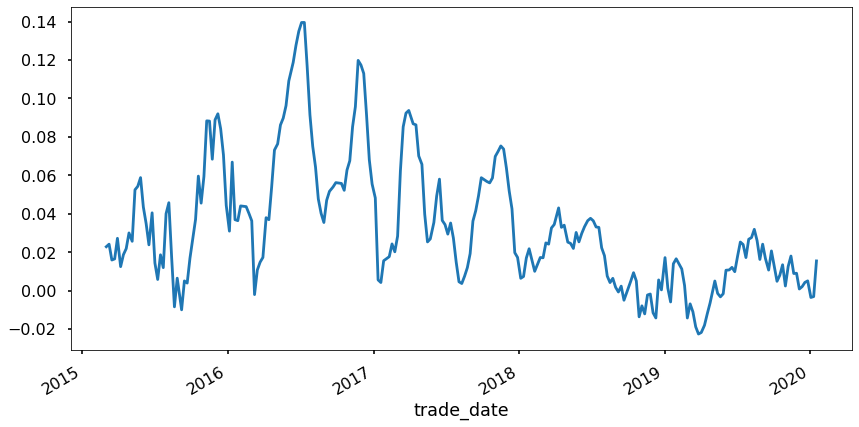

In [5]:
ic_series = total_data.groupby('trade_date').apply(lambda x: np.corrcoef(x['neutralized_factors'], x['dx'])[0, 1])
ic_series.rolling(window=7).mean().plot(figsize=(14, 7))

## 3. 行业内IR计算
---------------------

In [6]:
# 获取行业数据

industry_category = engine.fetch_industry_range(universe, dates=dates)
total_data = pd.merge(total_data, industry_category, on=['trade_date', 'code']).dropna()

In [7]:
# 行业IC的计算
industry_ic = total_data.groupby(['trade_date', 'industry']).apply(lambda x: np.corrcoef(x['neutralized_factors'], x['dx'])[0, 1])

<AxesSubplot:xlabel='industry'>

/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26426 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 35774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22791 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 21307 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 33647 missing from current font.
  font.set_

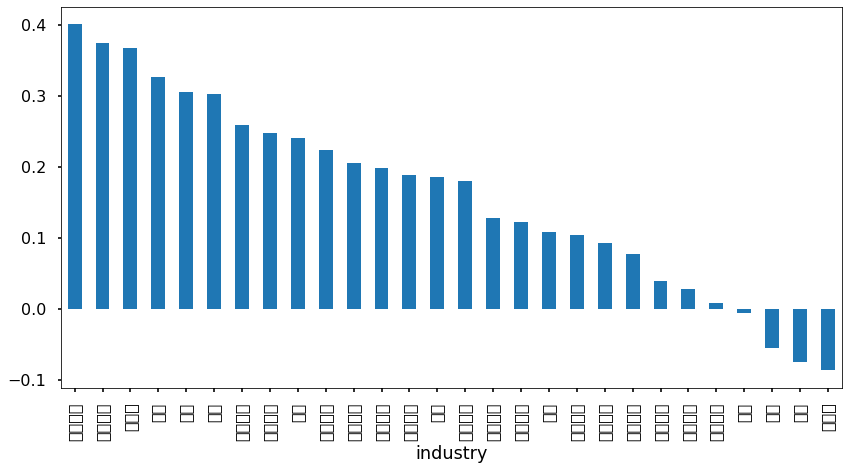

In [8]:
# 行业IR的计算ic.mean/ic.std

(industry_ic.groupby(level=1).mean() / industry_ic.groupby(level=1).std()).sort_values(ascending=False).plot(kind='bar', figsize=(14, 7))